## Homework 1 - Galaxy Morphology Classification

For the first supporting project of fast.ai 'Deep learning for coders' course I am going to apply the RESNET image classfication model together with the Galaxy Zoo Data Kaggle dataset (https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data) to produce a model that is capable of taking images of distant Galaxies and classifying them into one of the various categories of Galaxy type.

The Galxaxy Zoo project (https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) is a crowdsourced astronomy project which asks members of the public to assist researchers in the classification of images of galaxies from various deep sky surveys based on their morphology. The projects inception came about when one of it's cofounders Kevin Schawinski, at the time an astrophysist at Oxford University, was asked to classify 900,000 images of galaxies taken from the Sloan Digital Sky Survey. He classified the first 50,000 himslef over a week and found it a distinctly tedious task and estimated a perfect graduate student working 24 hours a day 7 days a week would take 3–5 years to classify all the galaxies in the sample once. The Galaxy Zoo project was started in hopes that by distributing the task over 20-30,000 members of the public the task could be greatly accelerated allowing the researchers to gain a well labeled data set of the Morphology of distant galaxies which could be instrumental in astrophysical research.

As of June 2020 the project has had over 48,000 volenters that have performed  1.4 million classifications although the project is still only 41% complete.

In December of 2013, a little under 4 years into the project the Galaxy Zoo team launched a Kaggle comptetion (https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/overview) which chalanged the worlds best data science experts to use their machine learning experitise create a model that would acurately classify the galaxy images from the project into their correct morphology classes. To help them in this they provided an 1.8Gb dataset of images together with crowdsourced probability distrobutions for their morphological classification. This is the dataset I will be using to train my own model.

At the time, 2014, the winning model had an error of 0.07491 so I am fascinated to know if 6 years later modern deep learning models are able to obtain a lower error rate or whether the result obtain in 2014 was close to the minium error on the data set.

First let's run our essential Jupyter directives, import the fast.ai libraries we will be using and set our default batch size.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [64]:
bs = 32 # May need to lower to 32 or 16 if graphics RAM is a constraint

Now that's out of the way let's download and extract out dataset.

In [23]:
#path = Path('C:\\Users\\jhon\\.fastai\\data\\galaxy_zoo')

path = Path('~/.fastai/data/galaxy_zoo')
files = path.ls()
images_path = files[0]
labels_csv_path = files[1]

The iamges of our dataset are to be found in the 'images_traing_rev' directory  with the file names of the images being the unique id of the particular galaxy. The 'training_solutions_rev1.csv' csv file contains the probability distributions of 11 different morphology classes for each galaxy as derived from the classifications made by Galaxy Zoo participants. Unfounteatly however this is not what we are after, we want a single label for each of the 11 classes rather than a probabaility distrobution. So in order to get useable class labels for each image we are going to have to first process the csv file selecting the highest probability labe for each class for each image

In [106]:
import csv
import pandas as pd
from numpy import argmax

names = []
labels = [[],[],[],[],[],[],[],[],[],[],[]]

with open(str(labels_csv_path)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            names.append('images_training_rev1\\'+row[0]+'.jpg')
            labels[0].append(argmax([float(p) for p in row[1:5]]))   # Q1. Is the object a smooth galaxy, a galaxy with features/disk or a star? 
            labels[1].append(argmax([float(p) for p in row[5:7]]))   # Q2. Is it edge-on? 
            labels[2].append(argmax([float(p) for p in row[7:9]]))  # Q3. Is there a bar?
            labels[3].append(argmax([float(p) for p in row[9:11]])) # Q4. Is there a spiral pattern?
            labels[4].append(argmax([float(p) for p in row[11:15]])) # Q5. How prominent is the central bulge?
            labels[5].append(argmax([float(p) for p in row[15:17]])) # Q6. Is there anything "odd" about the galaxy?
            labels[6].append(argmax([float(p) for p in row[17:20]])) # Q7. How round is the smooth galaxy?
            labels[7].append(argmax([float(p) for p in row[20:27]])) # Q8. What is the odd feature?
            labels[8].append(argmax([float(p) for p in row[27:30]])) # Q9. What shape is the bulge in the edge-on galaxy?
            labels[9].append(argmax([float(p) for p in row[30:33]])) # Q10. How tightly wound are the spiral arms?
            labels[10].append(argmax([float(p) for p in row[33:39]]))# Q11. How many spiral arms are there?
            line_count += 1

    
len(names)
df_main = pd.DataFrame(data={'names':names, 'smooth':labels[0], 'edge_on':labels[1], 'bar':labels[2], 'spiral':labels[3], 'bulge':labels[4], 'odd':labels[5], 'smoothness':labels[6], 'odd_detais':labels[7], 'bluge_shape':labels[8], 'arm_tightness':labels[9], 'arms':labels[10] })
df_spiral = df[['names', 'spiral']]

Now that we have a dataframe with the correct filenames and labels of our images to the apropriate classification we can actually load the dataset into python as a ImageDataBunch object.

In [107]:
data = ImageDataBunch.from_df(path, df_spiral, ds_tfms=get_transforms(), size=212, bs=bs)
data.classes

[0, 1]

Now we should note that the majority of classes that appear as possibilities in the csv are never actually observed as the highest probability class for an  image. This has potentially detrimental implications as to the genreralizability of our model to datasets the contain elements of the unseen classes but this is a defficeny of the data set rather than our model. 

Before we train our model let's take a look at some of the images that apear in the dataset.

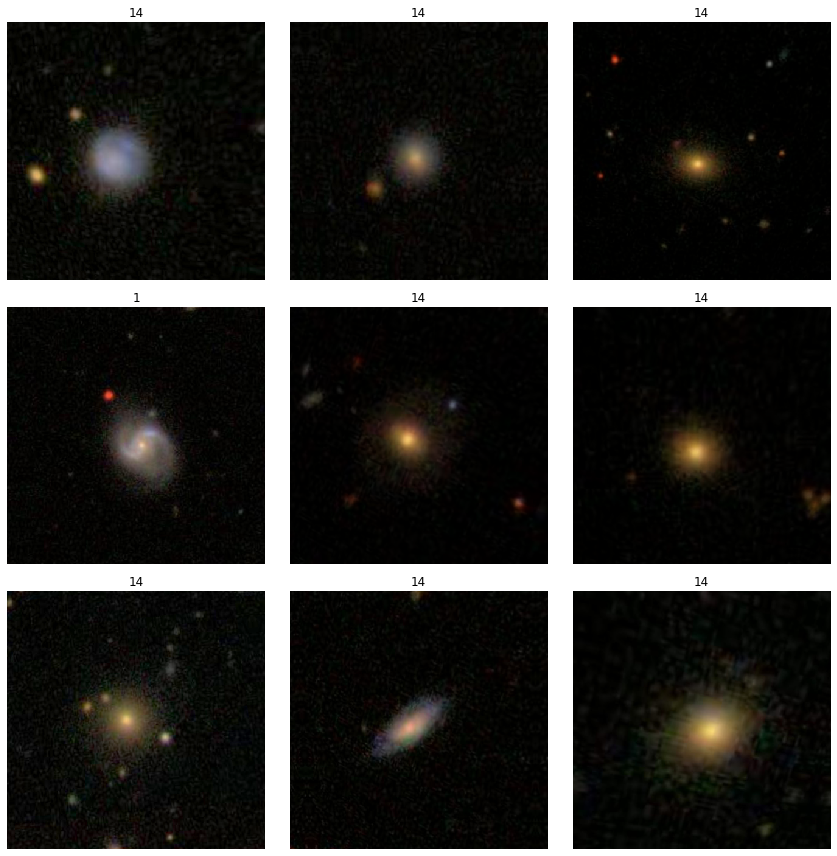

In [61]:
data.show_batch(rows=3)

Beautiful! It would seem from the images that 0, 13 and 14 are classes of eliptical galaxy while 1 and 2 are beautiful spiral galaxies. Each of these galaxies most like contains on the order 100 billion stars. The human mind simply fails before objects of such majesty and scale!

Anyway back to the data science...

Now the we have loaded our labeled dataset we can finally begin to construct and train our model. We will be using various different versions of the ResNet CNN, experimenting with different numbers of layers as well as different learning rates. As a first pass we will train a 'resnet18' model, first only allowing the last few layers to change their weights but then unfreezing the model and allowing all the weights to addapt to our dataset (with some constraints on learning rate). 

First we define and train the model.

In [69]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.988356,0.880021,0.339992,48:51


KeyboardInterrupt: 

In [ ]:
learn.save('stage-1')